## Import libraries
We start by importing necessary libraries. Myoelectric digital twin is part of the ``neurodec`` software. Apart from standard auxilitary libraries we also need ``meshio`` library to work with
``.stl`` surfaces

In [1]:
%config Completer.use_jedi = False

import glob
import os
import json

import matplotlib.pyplot as plt
import trimesh
import numpy as np

import neurodec as nd

nd.mdt._API_URL = "http://35.173.188.106:8001/"
nd.mdt.wait = False  # Set to true to wait step by step.

## Load model surfaces
Subject's forearm anatomy is represented by ``.stl`` meshes of the different tissue surfaces: upper skin, lower skin, individual muscles and bones.

The surface filename for each muscle is stored in ``muscles_description.json`` file.

We load each mesh with meshio package and create a ``nd.mdt.Surface`` for each tissue surface.

In [2]:
def load_surface(filename: str):
    mesh = trimesh.load_mesh(filename)
    return mesh.vertices, mesh.faces

MODEL_DIR = "/<your-data-path>/right-arm-template"

muscles_description_fname = os.path.join(MODEL_DIR, 'muscles_description.json')
with open(muscles_description_fname) as f:
    muscles_description = json.load(f)

In [3]:
bones = []
for filename in glob.glob(os.path.join(MODEL_DIR, 'bones', '*.stl')):
    vertices, triangles = load_surface(filename)
    bones.append(nd.mdt.Surface.new(vertices, triangles, nd.mdt.SurfaceType.BONE))

In [4]:
muscles = []    
for muscle in muscles_description['muscles']:
    fname = os.path.join(MODEL_DIR, 'muscles', muscle['fname'])
    vertices, triangles = load_surface(fname)
    muscles.append(nd.mdt.Surface.new(vertices, triangles, nd.mdt.SurfaceType.MUSCLE, label=muscle['label']))

In [5]:
skins = []

filename = os.path.join(MODEL_DIR, 'skin', 'inner.stl')
vertices, triangles = load_surface(filename)
skins.append(nd.mdt.Surface.new(vertices, triangles, nd.mdt.SurfaceType.INNER_SKIN))

filename = os.path.join(MODEL_DIR, 'skin', 'outer.stl')
vertices, triangles = load_surface(filename)
skins.append(nd.mdt.Surface.new(vertices, triangles, nd.mdt.SurfaceType.OUTER_SKIN))

print([str(s) for s in skins])

['Surface(26, Status.READY, SurfaceType.INNER_SKIN)', 'Surface(27, Status.READY, SurfaceType.OUTER_SKIN)']


## Generate volume conductor

Volume conductor is a function of anatomy surfaces and conductivities per tissue. Here, the default conductivity values are used.

In [6]:
conductor = nd.mdt.Conductor.new(bones + muscles + skins)

## Generate bracelet elctrodes

We generate a bracelet of electrodes made of ten rings. Each ring has 16 equidistant electrodes of 3mm radius. Disctance between rings is 9 mm.

Note that user can create electrodes by directly providing their centers and radii with `nd.mdt.Electrode.new(location, radius)`.

In [7]:
outer_skin_surface = skins[1]
radius = 0.003  # in meters
first_electrode_location = np.array([-0.247705, -0.083379, 0.838751])
rings_normal = np.array([0.17797643704463834, 0.19429176558661732, 0.9646632042750106])
n_rings = 10
distance_between_rings = 0.009  # in meters
n_electrodes_per_ring = 16

bracelet = nd.mdt.ElectrodeBracelet.new(
    outer_skin_surface, radius, first_electrode_location, rings_normal, 
    n_rings, distance_between_rings, n_electrodes_per_ring)

You can save generated electrodes as spheres with `trimesh` for futher visualization

In [ ]:
print(bracelet.electrodes[0].location)

for i, electrode in enumerate(bracelet.electrodes):
    sphere = trimesh.creation.icosphere()
    sphere.vertices = sphere.vertices * electrode.radius
    sphere.vertices = sphere.vertices + electrode.location
    sphere.export(MODEL_DIR + f'/elec_{i}.stl')

## Generate forward solver

Forward solver is a function of volume conductor and electrodes

In [9]:
forward_solution = nd.mdt.ForwardSolution.new(conductor, bracelet.electrodes)

## Generate fiber geometry

User can directly provide the number of fibers, or it can be automatically estimated from the avarage fiber radius.

Start and ending planes for fibers are stored in the ``muscle_description``.

In [10]:
fibers_per_muscle = []
for i, muscle in enumerate(muscles):
    plane_origins = muscles_description['muscles'][i]['plane_origins']
    plane_normals = muscles_description['muscles'][i]['plane_normals']
    fibers = nd.mdt.Fibers.new(muscle, plane_origins, plane_normals)
    fibers_per_muscle.append(fibers)

## Generate fiber basis

Fiber basis is a function of fibers and forward solution.

In [11]:
fiber_basis_per_muscle = []
for i, fibers in enumerate(fibers_per_muscle):
    fiber_basis = nd.mdt.FiberBasis.new(fibers, forward_solution)
    fiber_basis_per_muscle.append(fiber_basis)

## Compute MUAPs

To compute MUAPs for each muscle, fiber properties and motor units (MUs) should be generated and a sampling frequancy (in Hz) should be provided.

Here, fiber properties are generated using default tendon, velocity and neuromascular junction values.

The number of MU should be specified. Here, default values for minimum and maximum relative MU areas are used.

In [12]:
SAMPLING_FREQUENCY = 8000
n_motor_units = 150

muaps_per_muscle = []
for fibers, fiber_basis in zip(fibers_per_muscle, fiber_basis_per_muscle):

    fiber_properties = nd.mdt.FiberProperties.new(fibers)
    
    motor_units = nd.mdt.MotorUnits.new(fibers, n_motor_units)
    
    muaps = nd.mdt.MotorUnitsActionPotentials.new(fibers, fiber_basis, fiber_properties, motor_units,
                                                  SAMPLING_FREQUENCY)
    muaps_per_muscle.append(muaps)

## Simulate a simple movement  

In [13]:
def single_muscle_activation(max_mvc, duration, peak_time, fs):
    n_time_samples = int((peak_time + duration / 2.) * fs)
    t = np.linspace(-np.pi / 2, np.pi + np.pi / 2, int(duration * fs))
    waveform = max_mvc * 0.5 * (np.sin(t) + 1.)
    i_0 = n_time_samples - len(waveform)
    muscle_activation = np.zeros(n_time_samples)
    muscle_activation[i_0:] = waveform
    return muscle_activation

def generate_movement(n_muscles, mean_max_mvc, std_max_mvc, duration, peak_time, fs):
    muscle_activations = []
    for i in range(n_muscles):
        max_mvc = np.random.uniform(mean_max_mvc - std_max_mvc,
                                    mean_max_mvc + std_max_mvc)
        max_mvc = np.clip(max_mvc, 0., 100.)
        muscle_activations.append(single_muscle_activation(max_mvc, duration, peak_time, fs))
    return muscle_activations

Print the list of muscle labels

In [14]:
for i, muscle in enumerate(muscles):
    print(i, muscle.label)

0 Extensor carpi radialis longus
1 Extensor carpi radialis brevis
2 Extensor carpi ulnaris
3 Flexor carpi radialis
4 Palmaris longus
5 Flexor carpi ulnaris humeral head
6 Flexor carpi ulnaris ulnar head
7 Pronator teres humeral head
8 Pronator teres ulnar head
9 Pronator quadratus
10 Supinator
11 Brachioradialis
12 Flexor digitorum superficialis humeroulnar head
13 Flexor digitorum superficialis radial head
14 Abductor pollicis longus
15 Anconeus
16 Extensor digiti minimi
17 Extensor digitorum
18 Extensor indicis
19 Extensor pollicis brevis
20 Extensor pollicis longus
21 Flexor digitorum profondus
22 Flexor pollicis longus


Select wrist extensors

In [15]:
muscle_idx = [0, 1, 2]

Generate a simple 2 second long muscle activation patern corresponding to a wrist extension of around 40%MVC at its peak.

In [16]:
np.random.seed(1)
n_muscles = len(muscle_idx)
mean_max_mvc = 40 # %MVC
std_max_mvc = 10 # add some inter muscle variability in %MVC
duration = 2. # sec
peak_time = 1.5 # sec
activations = generate_movement(n_muscles, mean_max_mvc, std_max_mvc, duration, peak_time, SAMPLING_FREQUENCY)

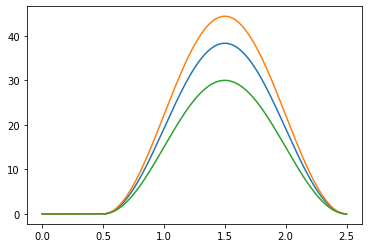

In [17]:
for single_activation in activations:
    times = np.arange(len(single_activation)) / SAMPLING_FREQUENCY
    plt.plot(times, single_activation)

Generate **impulse trains** for each muscle of interest

In [18]:
impulse_trains_per_muscle = []
for muscle_id, single_activation in zip(muscle_idx, activations):
    impulse_trains_per_muscle.append(nd.mdt.ImpulseTrains.new(muaps_per_muscle[muscle_id],
                                                              single_activation,
                                                              random_seed=0))

Assemble **raw sEMG signal** from muaps and impulse trains, and load the resulting data.

In [19]:
emg_per_muscle = []
for impulse_trains in impulse_trains_per_muscle:
    emg = nd.mdt.Electromyography.new(impulse_trains)
    emg.wait() # wait for the computation to finish before loading the EMG data
    emg_per_muscle.append(emg.data.copy())

Sum up EMG signals of individual muscles

In [20]:
min_length = np.min([e.shape[1] for e in emg_per_muscle])
emg_total = np.sum([e[:, :min_length] for e in emg_per_muscle], axis=0)

Plot the results

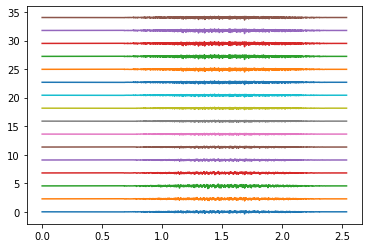

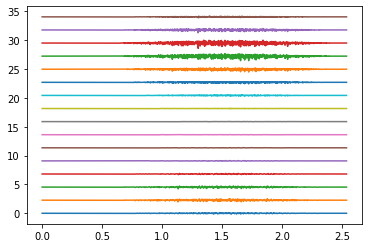

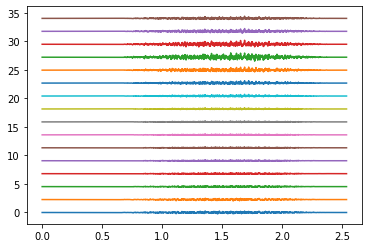

In [21]:
times = np.arange(emg_total.shape[1]) / SAMPLING_FREQUENCY
plot_shift = np.ptp(emg_total)
rings_to_plot = [0, 4, 9]

for ring in rings_to_plot:
    emg_to_plot = emg_total[ring*16:(ring+1)*16]
    plt.figure()
    plt.plot(times, emg_to_plot.T + plot_shift * np.arange(16))
    plt.show()